In [9]:
from transformers import AutoModelForVision2Seq, AutoTokenizer, AutoImageProcessor, StoppingCriteria, AutoModel
import torch
model_name_or_path = "Salesforce/xgen-mm-phi3-mini-instruct-interleave-r-v1.5"
# model_name_or_path = "/home/allets/.cache/huggingface/hub/models--Salesforce--xgen-mm-phi3-mini-instruct-interleave-r-v1.5/snapshots/bc8b948bfee232a0fa8422134dd4375deaea0cc8"
model = AutoModelForVision2Seq.from_pretrained(model_name_or_path, trust_remote_code=True)
# model = AutoModel.from_pretrained(model_name_or_path, trust_remote_code=True)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, trust_remote_code=True, use_fast=False, legacy=False)
image_processor = AutoImageProcessor.from_pretrained(model_name_or_path, trust_remote_code=True)
tokenizer = model.update_special_tokens(tokenizer)

Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.10s/it]


cpu


In [10]:
import json
import PIL
import textwrap
import IPython.display as display
from IPython.display import Image

with open('./test_samples/test.json') as f:
    data = json.load(f)
def apply_prompt_template(prompt):
    s = (
                '<|system|>\nA chat between a curious user and an artificial intelligence assistant. '
                "The assistant gives helpful, detailed, and polite answers to the user's questions.<|end|>\n"
                f'<|user|>\n{prompt}<|end|>\n<|assistant|>\n'
            )
    return s 

In [11]:
model = model.to('cuda')
model.eval()
tokenizer.padding_side = "left"
tokenizer.eos_token = '<|end|>'

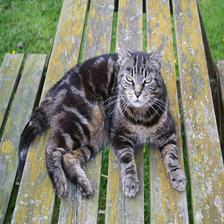

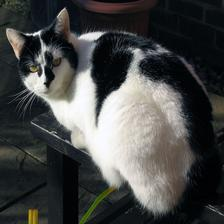

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (CUDABFloat16Type) should be the same

In [12]:
import os

for sample in data:
    image_list = []
    image_sizes = []
    for fn in sample['image_path']:
        # fn = os.path.join('/export/home/manlis/xgen-mm-phi3-mini-instruct-r-v1.5', fn)
        img = PIL.Image.open(fn)
        display.display(Image(filename=fn, width=300))
        image_list.append(image_processor([img], image_aspect_ratio='anyres')["pixel_values"].cuda().bfloat16())
        image_sizes.append(img.size)
    inputs = {
        "pixel_values": [image_list]
    }
    for query in sample['question']:
        prompt = apply_prompt_template(query)
        language_inputs = tokenizer([prompt], return_tensors="pt")
        inputs.update(language_inputs)
        # To cuda
        for name, value in inputs.items():
            if isinstance(value, torch.Tensor):
                inputs[name] = value.cuda()
        generated_text = model.generate(**inputs, image_size=[image_sizes],
                                        pad_token_id=tokenizer.pad_token_id,
                                        eos_token_id=tokenizer.eos_token_id,
                                        temperature=0.05,
                                        do_sample=False, max_new_tokens=1024, top_p=None, num_beams=1,
                                        )
        prediction = tokenizer.decode(generated_text[0], skip_special_tokens=True).split("<|end|>")[0]
        print("User: ", query)
        print("Assistant: ", textwrap.fill(prediction, width=100))
    print("-"*120)